   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.2 MB/s eta 0:00:00
Number of patches: 64


100%|██████████| 170M/170M [00:01<00:00, 93.2MB/s]


Model created successfully!
Total parameters: 9,507,466
Test image shape: (32, 32, 3)


/tmp/ipython-input-1-855810607.py:262: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree.leaves (jax v0.4.25 or newer) or jax.tree_util.tree_leaves (any JAX version).
  total_params = sum(x.size for x in jax.tree_leaves(eqx.filter(model, eqx.is_array)))


Forward pass successful! Output shape: (10,)
Output logits: [-0.53830117  0.05221536 -0.7119821   0.06731322 -0.5369498   0.05684045
  0.05840513 -1.4078466  -0.5896492  -0.4450108 ]

Training for 30000 steps...
Starting training...
Image shape: (64, 32, 32, 3), range: [-1.989, 2.126]
Labels shape: (64,), unique labels: [0 1 2 3 4 5 6 7 8 9]
Step     0: Loss = 2.5149
Step  2000: Loss = 1.6200
Step  4000: Loss = 1.2007
Step  6000: Loss = 1.1891
Step  8000: Loss = 0.9414
Step 10000: Loss = 0.8882
Step 12000: Loss = 0.8634
Step 14000: Loss = 0.8052
Step 16000: Loss = 0.5355
Step 18000: Loss = 0.6058
Step 20000: Loss = 0.3557
Step 22000: Loss = 0.7791
Step 24000: Loss = 0.5652
Step 26000: Loss = 0.6239
Step 28000: Loss = 0.5773
Evaluating on test set...
  Progress: 20/156 batches, Accuracy so far: 0.7875
  Progress: 40/156 batches, Accuracy so far: 0.7969
  Progress: 60/156 batches, Accuracy so far: 0.7953
  Progress: 80/156 batches, Accuracy so far: 0.7963
  Progress: 100/156 batches, Acc

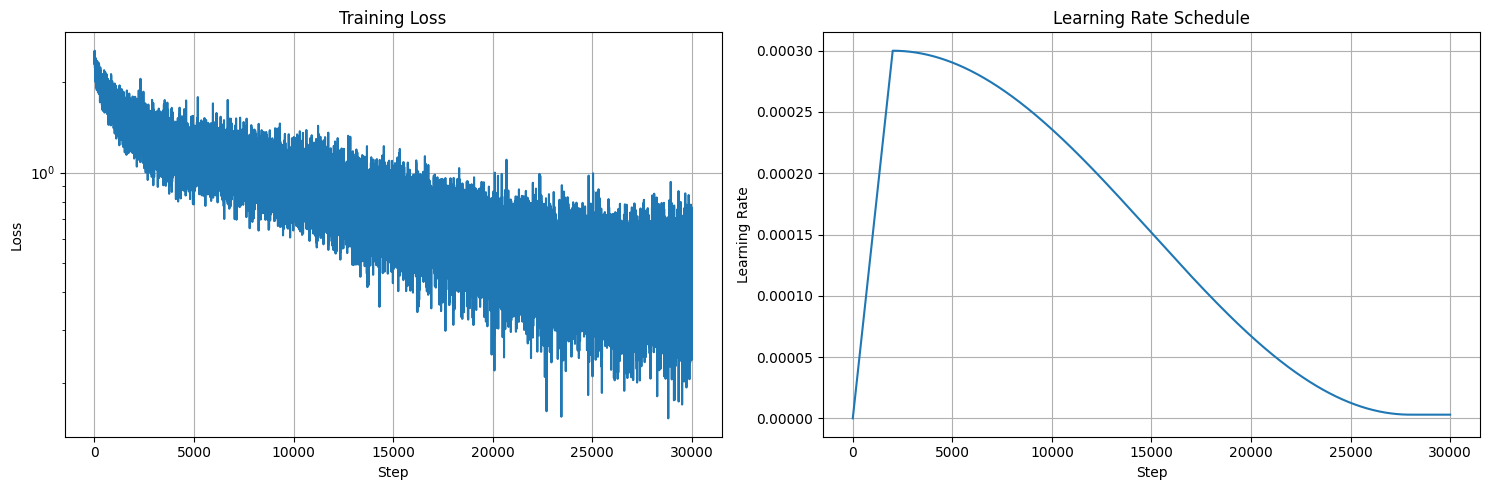

In [1]:
!pip install equinox
!pip install einops
!pip install jaxtyping


lr = 0.0003
batch_size = 64
patch_size = 4
num_steps = 30000
image_size = (32, 32, 3)
embedding_dim = 384
hidden_dim = 768
num_heads = 12
num_layers = 8
dropout_rate = 0.15
height, width, channels = image_size
num_classes = 10

num_patches = (height // patch_size) * (width // patch_size)
print(f"Number of patches: {num_patches}")  # Should be 64

"""## Data Loading"""

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Data augmentation
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),  # CIFAR-10 statistics
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

train_dataset = torchvision.datasets.CIFAR10("CIFAR", train=True, download=True, transform=train_transforms)
test_dataset = torchvision.datasets.CIFAR10("CIFAR", train=False, download=True, transform=test_transforms)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import optax
from jaxtyping import Array, PRNGKeyArray, Float
from einops import rearrange

class PatchEmbedding(eqx.Module):
    linear: eqx.nn.Linear
    patch_size: int

    def __init__(self, patch_size: int, embedding_dim: int, key: PRNGKeyArray):
        self.patch_size = patch_size
        patch_dim = patch_size * patch_size * 3
        self.linear = eqx.nn.Linear(in_features=patch_dim, out_features=embedding_dim, key=key)

    def __call__(self, x: Array) -> Array:
        H, W, C = x.shape

        x_patches = rearrange(x, '(h p1) (w p2) c -> (h w) (p1 p2 c)',
                             p1=self.patch_size, p2=self.patch_size)

        embeddings = jax.vmap(self.linear)(x_patches)
        return embeddings

class PositionalEmbedding(eqx.Module):
    pos_embed: Array

    def __init__(self, num_patches: int, embedding_dim: int, *, key: PRNGKeyArray):
        self.pos_embed = jr.normal(key, (num_patches + 1, embedding_dim)) * 0.02

    def __call__(self, x: Array) -> Array:
        return x + self.pos_embed

class Attention(eqx.Module):
    attention: eqx.nn.MultiheadAttention
    norm: eqx.nn.LayerNorm
    dropout: eqx.nn.Dropout

    def __init__(self, embedding_dim: int, num_heads: int, dropout_rate: float, key: PRNGKeyArray):
        self.attention = eqx.nn.MultiheadAttention(
            num_heads=num_heads,
            query_size=embedding_dim,
            key=key,
            dropout_p=dropout_rate
        )
        self.norm = eqx.nn.LayerNorm(shape=embedding_dim)
        self.dropout = eqx.nn.Dropout(p=dropout_rate)

    def __call__(self, x: Array, *, key: PRNGKeyArray = None, inference: bool = False) -> Array:
        normed = jax.vmap(self.norm)(x)
        attended = self.attention(normed, normed, normed, key=key, inference=inference)
        if not inference and key is not None:
            attended = self.dropout(attended, key=key)
        return x + attended

class MLP(eqx.Module):
    linear1: eqx.nn.Linear
    linear2: eqx.nn.Linear
    norm: eqx.nn.LayerNorm
    dropout: eqx.nn.Dropout

    def __init__(self, embedding_dim: int, hidden_dim: int, dropout_rate: float, key: PRNGKeyArray):
        key1, key2 = jr.split(key)
        self.linear1 = eqx.nn.Linear(in_features=embedding_dim, out_features=hidden_dim, key=key1)
        self.linear2 = eqx.nn.Linear(in_features=hidden_dim, out_features=embedding_dim, key=key2)
        self.norm = eqx.nn.LayerNorm(shape=embedding_dim)
        self.dropout = eqx.nn.Dropout(p=dropout_rate)

    def __call__(self, x: Array, *, key: PRNGKeyArray = None, inference: bool = False) -> Array:
        normed = jax.vmap(self.norm)(x)
        hidden = jax.vmap(self.linear1)(normed)
        hidden = jax.nn.gelu(hidden)
        if not inference and key is not None:
            hidden = self.dropout(hidden, key=key)
        output = jax.vmap(self.linear2)(hidden)
        if not inference and key is not None:
            output = self.dropout(output, key=key)
        return x + output

class EncoderBlock(eqx.Module):
    attention: Attention
    mlp: MLP

    def __init__(self, embedding_dim: int, hidden_dim: int, num_heads: int,
                 dropout_rate: float, key: PRNGKeyArray):
        key1, key2 = jr.split(key)
        self.attention = Attention(embedding_dim, num_heads, dropout_rate, key1)
        self.mlp = MLP(embedding_dim, hidden_dim, dropout_rate, key2)

    def __call__(self, x: Array, *, key: PRNGKeyArray = None, inference: bool = False) -> Array:
        key1, key2 = jr.split(key, 2) if key is not None else (None, None)
        x = self.attention(x, key=key1, inference=inference)
        x = self.mlp(x, key=key2, inference=inference)
        return x


class ClassificationHead(eqx.Module):
    classifier : eqx.nn.Linear
    dropout: eqx.nn.Dropout

    def __init__(self, embedding_dim: int, num_classes: int, dropout_rate: float, *, key: PRNGKeyArray):
        classifier_key = key

        self.classifier = eqx.nn.Linear(in_features=embedding_dim, out_features=num_classes, key=classifier_key)
        self.dropout = eqx.nn.Dropout(p=dropout_rate)

    def __call__(self, cls_token: Array, *, key: PRNGKeyArray | None = None, inference: bool = False) -> Array:
        if not inference and key is not None:
            cls_token = self.dropout(cls_token, key=key)
        return self.classifier(cls_token)


class VIT(eqx.Module):
    patch_embed: PatchEmbedding
    cls_token: Array
    pos_embed: PositionalEmbedding
    encoder_blocks: list
    final_norm: eqx.nn.LayerNorm
    classification_head: ClassificationHead
    dropout: eqx.nn.Dropout

    def __init__(self, patch_size: int, embedding_dim: int, hidden_dim: int,
                 num_heads: int, num_layers: int, num_classes: int,
                 dropout_rate: float, num_patches: int, *, key: PRNGKeyArray):
        keys = jr.split(key, num_layers + 6)
        self.patch_embed = PatchEmbedding(patch_size, embedding_dim, keys[0])
        self.cls_token = jr.normal(keys[1], (1, embedding_dim)) * 0.02
        self.pos_embed = PositionalEmbedding(num_patches, embedding_dim, key=keys[2])
        self.encoder_blocks = [
            EncoderBlock(embedding_dim, hidden_dim, num_heads, dropout_rate, keys[3 + i])
            for i in range(num_layers)
        ]
        self.final_norm = eqx.nn.LayerNorm(shape=embedding_dim)
        self.classification_head = ClassificationHead(embedding_dim, num_classes, dropout_rate, key=keys[3 + num_layers])
        self.dropout = eqx.nn.Dropout(p=dropout_rate)

    def __call__(self, x: Array, *, key: PRNGKeyArray = None, inference: bool = False) -> Array:
        keys = jr.split(key, len(self.encoder_blocks) + 2) if key is not None else [None] * (len(self.encoder_blocks) + 2)
        x = self.patch_embed(x)
        x = jnp.concatenate([self.cls_token, x], axis=0)
        x = self.pos_embed(x)
        if not inference:
            x = self.dropout(x, key=keys[0])
        for i, block in enumerate(self.encoder_blocks):
            x = block(x, key=keys[i + 1], inference=inference)
        cls_token = self.final_norm(x[0])
        logits = self.classification_head(cls_token, key=keys[-1], inference=inference)
        return logits

# Training
@eqx.filter_value_and_grad
def compute_loss(model, images, labels, key):
    # Process batch of images
    def single_forward(image, subkey):
        return model(image, key=subkey, inference=False)

    keys = jr.split(key, len(images))
    logits = jax.vmap(single_forward)(images, keys)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
    return jnp.mean(loss)

@eqx.filter_jit
def train_step(model, opt_state, images, labels, optimizer, key):
    loss, grads = compute_loss(model, images, labels, key)
    updates, new_opt_state = optimizer.update(grads, opt_state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_opt_state, loss

def train_model(model, optimizer, trainloader, num_steps):
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    losses = []

    def infinite_dataloader():
        while True:
            yield from trainloader

    print("Starting training...")
    key = jr.PRNGKey(0)

    for step, (images, labels) in zip(range(num_steps), infinite_dataloader()):
        # Convert to JAX arrays and proper format
        images = jnp.array(images.numpy().transpose(0, 2, 3, 1))  # BCHW -> BHWC
        labels = jnp.array(labels.numpy())

        if step == 0:
            print(f"Image shape: {images.shape}, range: [{images.min():.3f}, {images.max():.3f}]")
            print(f"Labels shape: {labels.shape}, unique labels: {jnp.unique(labels)}")

        key, subkey = jr.split(key)
        model, opt_state, loss = train_step(model, opt_state, images, labels, optimizer, subkey)
        losses.append(float(loss))

        if step % 2000 == 0:
            print(f"Step {step:5d}: Loss = {loss:.4f}")

    return model, losses


key = jr.PRNGKey(42)
model = VIT(
    patch_size=patch_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    num_classes=num_classes,
    dropout_rate=dropout_rate,
    num_patches=num_patches,
    key=key
)

print("Model created successfully!")
total_params = sum(x.size for x in jax.tree_leaves(eqx.filter(model, eqx.is_array)))
print(f"Total parameters: {total_params:,}")

# Test forward pass
test_batch = next(iter(trainloader))
test_image = jnp.array(test_batch[0][0].numpy().transpose(1, 2, 0))  # Single image, CHW -> HWC
print(f"Test image shape: {test_image.shape}")

try:
    output = model(test_image, key=jr.PRNGKey(0), inference=True)
    print(f"Forward pass successful! Output shape: {output.shape}")
    print(f"Output logits: {output}")
except Exception as e:
    print(f"Forward pass failed: {e}")
    import traceback
    traceback.print_exc()

warmup_steps = 2000
total_steps = num_steps

schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=lr,
    warmup_steps=warmup_steps,
    decay_steps=total_steps - warmup_steps,
    end_value=lr * 0.01
)

optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate=schedule, weight_decay=0.01)
)

print(f"\nTraining for {num_steps} steps...")
trained_model, losses = train_model(model, optimizer, trainloader, num_steps)

def evaluate(model, testloader):
    """Evaluate on test set"""
    correct = 0
    total = 0

    print("Evaluating on test set...")
    for i, (images, labels) in enumerate(testloader):
        images = jnp.array(images.numpy().transpose(0, 2, 3, 1))
        labels = jnp.array(labels.numpy())

        def predict(image):
            logits = model(image, key=None, inference=True)
            return jnp.argmax(logits)

        predictions = jax.vmap(predict)(images)
        correct += jnp.sum(predictions == labels)
        total += len(labels)

        if (i + 1) % 20 == 0:
            current_acc = float(correct) / total
            print(f"  Progress: {i+1}/{len(testloader)} batches, Accuracy so far: {current_acc:.4f}")

    return float(correct) / total

accuracy = evaluate(trained_model, testloader)
print(f"\nFinal Results:")
print(f"Full test accuracy: {accuracy:.4f}")
print(f"Final loss: {losses[-1]:.4f}")
print(f"Best loss: {min(losses):.4f}")


import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(losses)
ax1.set_title('Training Loss')
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.set_yscale('log')
ax1.grid(True)

# Learning rate schedule visualization
steps = jnp.arange(num_steps)
lrs = [schedule(step) for step in steps]
ax2.plot(lrs)
ax2.set_title('Learning Rate Schedule')
ax2.set_xlabel('Step')
ax2.set_ylabel('Learning Rate')
ax2.grid(True)

plt.tight_layout()
plt.show()